# Relax Inc. Analysis
<strong>Problem</strong>: Determine the factors that predict future user adoption.

## User Adoption
User adoption is described as "a user who has logged into the product on three separate days in at least one seven-day period." This was calculated by creating a pivot table of logins and users and then resampling the data by 1 week intervals. If the user had more than 3 logins in one of the weeks, then the user was considered adopted. There are less than 1500 adopted users in the dataset, which means there are ~1050 non-adopted users, as seen in the plot below.

## Attributes Added
The Relax Inc. dataset contained a last session created, which was used to create a feature called days since last session. By taking the newest date in the column and subtracting the value, we can get the days since the last session. The next feature created was the domain of the email address provided. This was extracted from each user in the dataset. The total number of logins from a user was also calculated for each user. The last two attributes created were based on whether the user was invited by another user and if the user was part of an organization.

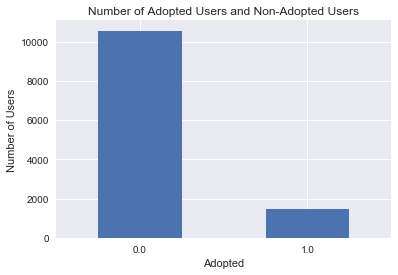

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

users_adopted = pd.read_csv('users_adopted.csv')
users_adopted.drop('Unnamed: 0', 1, inplace=True)
creation_source = users_adopted.pivot_table(index='adopted', columns='creation_source', values='object_id', aggfunc=len)
opted_in = users_adopted.pivot_table(index='adopted', columns='opted_in_to_mailing_list', values='object_id', aggfunc=len)
market = users_adopted.pivot_table(index='adopted', columns='enabled_for_marketing_drip', values='object_id', aggfunc=len)
org = users_adopted.pivot_table(index='adopted', columns='belong_to_org', values='object_id', aggfunc=len)
org_id = users_adopted.pivot_table(index='adopted', columns='org_id', values='object_id', aggfunc=len)
user_invite = users_adopted.pivot_table(index='adopted', columns='invited_by_user', values='object_id', aggfunc=len)
last_login = users_adopted.groupby('adopted')['days_since_last_login'].mean()
login = users_adopted.groupby('adopted')['logins'].mean()
domain = users_adopted.pivot_table(index='adopted', columns='email_domain', values='object_id', aggfunc=len)

users_adopted['adopted'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of Users')
plt.xlabel('Adopted')
plt.title('Number of Adopted Users and Non-Adopted Users')
plt.show()

## Important Features
When you break down adopted users and non-adopted users by the average number of days since the last login, there is a big difference between the two (300 for non-adopted vs ~50 for adopted). The same goes for the average number of logins for adopted (~140) vs. non-adopted users (< 10). These two features are the most important.

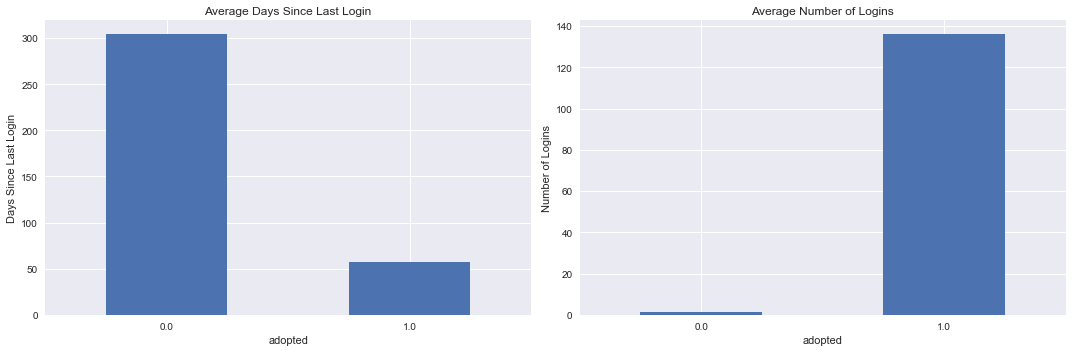

In [2]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
last_login.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Days Since Last Login')
plt.title('Average Days Since Last Login')

plt.subplot(1,2,2)
login.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of Logins')
plt.title('Average Number of Logins')

plt.tight_layout()
plt.show()

The Creation Source seems to have a small importance for adoption. Personal projects seem be the highest predictor of whether a user adopts the product because there is a stark difference between the adopted users and non-adopted users.

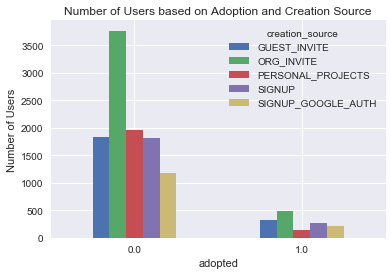

In [3]:
plt.figure(figsize=(15,5))
creation_source.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of Users')
plt.title('Number of Users based on Adoption and Creation Source')
plt.show()

The next three plots based on whether a user was part of the mailing list, if the user was invited by another user, and if the user was part of an organization did not show as much importance like the number of logins or the days since the last login. There is a big difference in adoption status for both opting in and out of the mailing list. There is also a large difference in adoption status between users that were invited by other users and those that were not. The org plot does not actually show anything important.

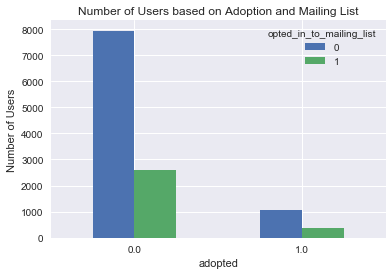

In [4]:
opted_in.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of Users')
plt.title('Number of Users based on Adoption and Mailing List')
plt.show()

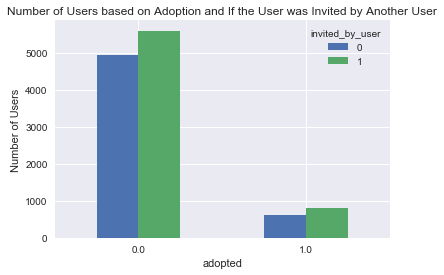

In [5]:
user_invite.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of Users')
plt.title('Number of Users based on Adoption and If the User was Invited by Another User')
plt.show()

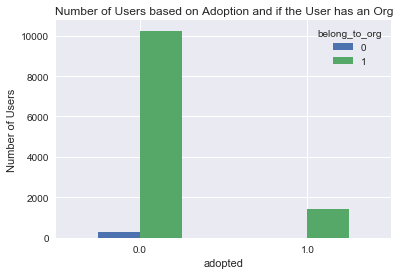

In [6]:
org.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of Users')
plt.title('Number of Users based on Adoption and if the User has an Org')
plt.show()

It was difficult to view the email domains in one plot as there were over 1000 email domains. The output of the table would be too large to view all of the columns as well. The same goes for the organization ids. These were not included in this report but they could ultimately be important features.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

users_adopted['creation_source'] = users_adopted['creation_source'].astype('category')
users_adopted['org_id'] = users_adopted['org_id'].astype('category')
users_adopted['email_domain'] = users_adopted['email_domain'].astype('category')

users_adopted = pd.get_dummies(users_adopted, columns=['creation_source','org_id','email_domain'], drop_first=True)

X = users_adopted.drop(['object_id','creation_time','name','email','last_session_creation_time','invited_by_user_id','adopted','belong_to_org'], 1)
y = users_adopted['adopted']

X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=35)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

rf1 = RandomForestClassifier(n_estimators=500, class_weight={0: 0.6, 1: 0.4}, criterion='entropy', max_depth=25, max_features='auto', n_jobs=-1, oob_score=True)
rf1.fit(X_train,y_train)
pred_rf = rf1.predict(X_test)
score_rf = rf1.score(X_test, y_test)
train_score_rf = rf1.score(X_train, y_train)

train_score_rf, score_rf

importance = list(rf1.feature_importances_)
features = list(X_train.columns)
feat_dict = {'features':features,'importance':importance}
feat_df = pd.DataFrame(feat_dict)

A Random Forest model was created to predict the whether a user will adopt the product or not. The model's accuracy was 97%, with a precision of .97. The recall was also .97 and the ROC AUC was .87. The model does really well in predicting whether a user will adopt the product or not.
<br><br>
Random Forests have a nice feature that shows how important they are. The top 10 important features are shown below.

In [8]:
feat_df.sort_values('importance', ascending=False).head(10)

,features,importance
2,logins,0.523156
3,days_since_last_login,0.205436
6,creation_source_PERSONAL_PROJECTS,0.015259
1536,email_domain_@yahoo.com,0.007591
5,creation_source_ORG_INVITE,0.007156
8,creation_source_SIGNUP_GOOGLE_AUTH,0.006977
717,email_domain_@gmail.com,0.006753
4,invited_by_user,0.006520
7,creation_source_SIGNUP,0.005967
0,opted_in_to_mailing_list,0.005903
